## The Problem:
When you're trying to search through a massive amount of text (like millions or billions of documents), you want to quickly find the most relevant information. To do this, we convert text into numerical representations called "vectors" and use these vectors to search.

However, because these vectors are compressed versions of the text, they might miss out on some details. As a result, the top search results might not always include the most useful information. If important info is further down the list, the search might miss it because it's only looking at the top few results.

## What Can We Do?
One approach is to increase the number of documents (let's say from the top 3 to the top 10) that we send to our AI to generate a response. This improves our chances of finding relevant information.

But there's a catch: AI systems (like language models) can only handle a certain amount of text at a time, called a "context window." If you stuff too much information into this window, the AI might get confused and perform worse, like trying to cram too much information into your brain at once.

## The Solution:
Instead of just dumping more documents into the AI's context window, we need to be smart about which documents we pick. This is where rerankers come in.

## Rerankers:
Rerankers are tools that take a closer look at the documents retrieved from the initial search and reorder them based on how relevant they are to the query. They do this by analyzing the query and the documents together, which helps them understand the context better and pick out the most useful information.

Even though rerankers are slower than the initial search, they are much more accurate. They help ensure that the most relevant documents are passed on to the AI, leading to better results.


In [17]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

In [18]:
loader = DirectoryLoader('./', glob="./*.txt", loader_cls=TextLoader)
docs = loader.load()

In [19]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=10,
    length_function=len
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

In [20]:
import os
# os.environ["GOOGLE_API_KEY"]=os.getenv("GOOGLE_API_KEY")
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001",google_api_key=os.getenv("GOOGLE_API_KEY"))
vectors = embeddings.embed_documents(doc_strings)

In [21]:
db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 6})

In [22]:
import umap
import numpy as np
from tqdm import tqdm

umap_transformer = umap.UMAP(random_state=0, transform_seed=0).fit(vectors)

/home/fx/Downloads/Projects/reranker-rag/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [23]:
def umap_embed(vectors, umap_transformer):
    umap_embeddings = np.array([umap_transformer.transform([vector])[0] for vector in tqdm(vectors)])
    return umap_embeddings

In [24]:
global_embeddings = umap_embed(vectors, umap_transformer)

100%|██████████| 65/65 [00:43<00:00,  1.50it/s]


In [25]:
global_embeddings

array([[10.428451 , 13.608632 ],
       [10.969886 , 11.94414  ],
       [12.242725 , 10.02356  ],
       [10.593955 , 12.835594 ],
       [11.381565 ,  9.746835 ],
       [12.581392 , 11.679139 ],
       [12.625462 , 11.565149 ],
       [10.053583 , 10.805386 ],
       [12.801433 , 11.46279  ],
       [12.710727 , 11.489691 ],
       [12.73828  , 11.601278 ],
       [10.854056 , 11.8555565],
       [13.010086 , 11.280299 ],
       [12.313394 , 10.166869 ],
       [12.17439  , 10.013516 ],
       [10.716252 , 12.788968 ],
       [13.09522  , 10.766002 ],
       [11.865057 ,  9.762846 ],
       [10.708084 , 12.709639 ],
       [10.490971 , 11.727838 ],
       [10.106676 , 11.188516 ],
       [ 9.9933605, 10.650376 ],
       [11.824997 , 12.853898 ],
       [12.547633 , 11.738985 ],
       [12.513482 , 11.749379 ],
       [10.812041 , 12.683859 ],
       [11.138178 ,  9.838744 ],
       [10.021607 , 10.776694 ],
       [10.395122 , 13.054457 ],
       [10.35541  ,  8.72534  ],
       [ 9

(6.97538845539093, 13.38664014339447, 4.95313708782196, 14.020798516273498)

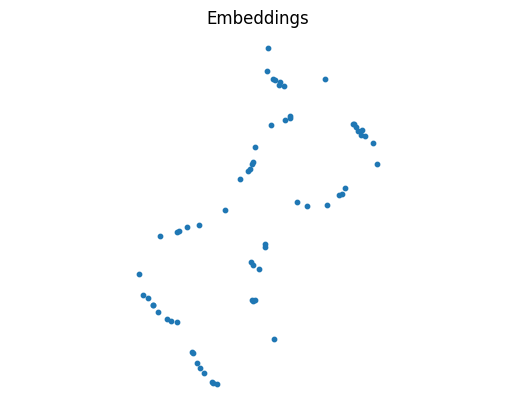

In [26]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(global_embeddings[:, 0], global_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Embeddings')
plt.axis('off')

In [27]:
def calc_global_embeddings(query, embeddings, retriever, umap_transformer, embed_function, global_embeddings):
    q_embedding = embeddings.embed_query(query)

    docs = retriever.get_relevant_documents(query)
    page_contents = [doc.page_content for doc in docs]
    vectors_content_vectors = embeddings.embed_documents(page_contents)

    query_embeddings = embed_function([q_embedding], umap_transformer)
    retrieved_embeddings = embed_function(vectors_content_vectors, umap_transformer)

    plt.figure()
    plt.scatter(global_embeddings[:, 0], global_embeddings[:, 1], s=10, color='gray')
    plt.scatter(query_embeddings[:, 0], query_embeddings[:, 1], s=150, marker='X', color='r')
    plt.scatter(retrieved_embeddings[:, 0], retrieved_embeddings[:, 1], s=50, facecolors='none', edgecolors='g')
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{query}')
    plt.axis('off')
    plt.show()


/home/fx/Downloads/Projects/reranker-rag/venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:151: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use invoke instead.
  warn_deprecated(
100%|██████████| 6/6 [00:03<00:00,  1.68it/s]


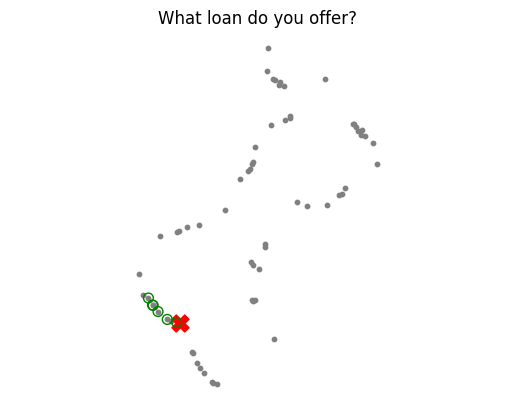

In [28]:
calc_global_embeddings("What loan do you offer?", embeddings, retriever, umap_transformer, umap_embed, global_embeddings)

100%|██████████| 6/6 [00:03<00:00,  1.68it/s]


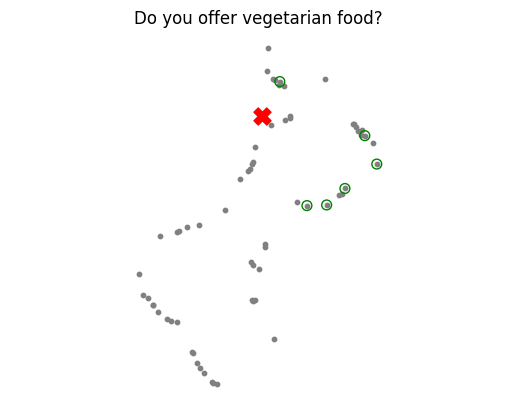

In [29]:
calc_global_embeddings("Do you offer vegetarian food?", embeddings, retriever, umap_transformer, umap_embed, global_embeddings)


### Query Expansion 

In [30]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI
os.environ["GOOGLE_API_KEY"]=os.getenv("GOOGLE_API_KEY")
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [41]:
from langchain.prompts import PromptTemplate

query = "Do you offer vegetarian food?"


QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five
    different versions of the given user question to retrieve relevant documents from a vector
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search.
    Provide these alternative questions separated by newlines. Only provide the query, no numbering.
    Original question: {question}""",
)

llm_chain = QUERY_PROMPT |llm
queries = llm_chain.invoke(query)
queries = list(queries.content.split("\n"))
# print(queries)

In [42]:
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

query = "Do you offer vegetarian food?"

output_parser = StrOutputParser()

QUERY_PROMPT = ChatPromptTemplate.from_messages(
     [
    (
        "system",
        """You are an AI language model assistant. Your task is to generate five
    different versions of the given user question to retrieve relevant documents from a vector
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search.
    Provide these alternative questions separated by newlines. Only provide the query, no numbering.
    Original question: {question}""",
    ),
    ("human", "{question}"),
]
)




In [43]:
queries

['What vegetarian options are available?',
 "What's on the menu for vegetarians?",
 'Can I get a meal without meat?',
 'Do you have plant-based dishes?',
 'Is there anything vegetarian-friendly? ',
 '']

In [46]:
docs = [retriever.get_relevant_documents(query) for query in queries]

In [47]:
unique_contents = set()
unique_docs = []
for sublist in docs:
    for doc in sublist:
        if doc.page_content not in unique_contents:
            unique_docs.append(doc)
            unique_contents.add(doc.page_content)
unique_contents = list(unique_contents)

In [48]:
unique_contents

['the overall dining experience.',
 'dietary preferences. Dishes like eggplant parmigiana and mushroom risotto are crafted with the same',
 'and gnocchi, each prepared with homemade pasta and cooked to perfection. The sauces, ranging from',
 'the same attention to detail and flavor as their meat-based counterparts.',
 'The pasta selection is a highlight of the menu, featuring classics like lasagna, ravioli, and',
 'The meat and fish dishes are equally impressive, with offerings like osso buco, saltimbocca, and',
 'La Bella Vita also prides itself on its vegetarian and vegan options, catering to all dietary',
 'savings strategies to more complex investment and tax planning concepts. These educational',
 'possible, providing support and advice at every step.',
 'to make informed financial decisions.',
 'and grilled branzino. These dishes are cooked with traditional methods, ensuring every bite is',
 'creating an unforgettable dining experience that keeps guests coming back for more.',
 '

# Cross-encoder re-ranking

In [49]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

/home/fx/Downloads/Projects/reranker-rag/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [50]:
pairs = []
for doc in unique_contents:
    pairs.append([query, doc])

In [51]:
scores = cross_encoder.predict(pairs)
scores

array([-10.925325 ,  -9.750738 , -10.969239 , -10.356451 , -10.774685 ,
        -8.007286 ,  -2.7005744, -11.276547 , -10.847548 , -11.144098 ,
       -10.625803 , -11.23642  , -10.663025 ], dtype=float32)

In [52]:
scored_docs = zip(scores, unique_contents)
sorted_docs = sorted(scored_docs, reverse=True)
sorted_docs

[(-2.7005744,
  'La Bella Vita also prides itself on its vegetarian and vegan options, catering to all dietary'),
 (-8.007286,
  'The meat and fish dishes are equally impressive, with offerings like osso buco, saltimbocca, and'),
 (-9.750738,
  'dietary preferences. Dishes like eggplant parmigiana and mushroom risotto are crafted with the same'),
 (-10.356451,
  'the same attention to detail and flavor as their meat-based counterparts.'),
 (-10.625803,
  'and grilled branzino. These dishes are cooked with traditional methods, ensuring every bite is'),
 (-10.663025,
  'from rich and creamy to light and zesty, are made with the freshest ingredients, bringing out the'),
 (-10.774685,
  'The pasta selection is a highlight of the menu, featuring classics like lasagna, ravioli, and'),
 (-10.847548, 'possible, providing support and advice at every step.'),
 (-10.925325, 'the overall dining experience.'),
 (-10.969239,
  'and gnocchi, each prepared with homemade pasta and cooked to perfection.

In [53]:
reranked_docs = [doc for _, doc in sorted_docs][0:8]
reranked_docs

['La Bella Vita also prides itself on its vegetarian and vegan options, catering to all dietary',
 'The meat and fish dishes are equally impressive, with offerings like osso buco, saltimbocca, and',
 'dietary preferences. Dishes like eggplant parmigiana and mushroom risotto are crafted with the same',
 'the same attention to detail and flavor as their meat-based counterparts.',
 'and grilled branzino. These dishes are cooked with traditional methods, ensuring every bite is',
 'from rich and creamy to light and zesty, are made with the freshest ingredients, bringing out the',
 'The pasta selection is a highlight of the menu, featuring classics like lasagna, ravioli, and',
 'possible, providing support and advice at every step.']

### Lost in the middle Problem

In [54]:
from langchain_community.document_transformers import (
    LongContextReorder
)

In [55]:
reordering = LongContextReorder()
reordered_docs = reordering.transform_documents(reranked_docs)
reordered_docs

['The meat and fish dishes are equally impressive, with offerings like osso buco, saltimbocca, and',
 'the same attention to detail and flavor as their meat-based counterparts.',
 'from rich and creamy to light and zesty, are made with the freshest ingredients, bringing out the',
 'possible, providing support and advice at every step.',
 'The pasta selection is a highlight of the menu, featuring classics like lasagna, ravioli, and',
 'and grilled branzino. These dishes are cooked with traditional methods, ensuring every bite is',
 'dietary preferences. Dishes like eggplant parmigiana and mushroom risotto are crafted with the same',
 'La Bella Vita also prides itself on its vegetarian and vegan options, catering to all dietary']